# HW 9
Nurvirta Monarizqa (nm2773)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
from sklearn.cluster import KMeans
import os 
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
# loading data
mtaRide = np.load(os.getenv('PUIDATA') + '/' + 'MTA_Fare.npy')
mtaRide = mtaRide.astype('float')
mtaRide[mtaRide == -1] = np.nan

# populating ridetype
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

# generate dates
dateRange = pd.date_range('21/05/2010', periods=194, freq='W')

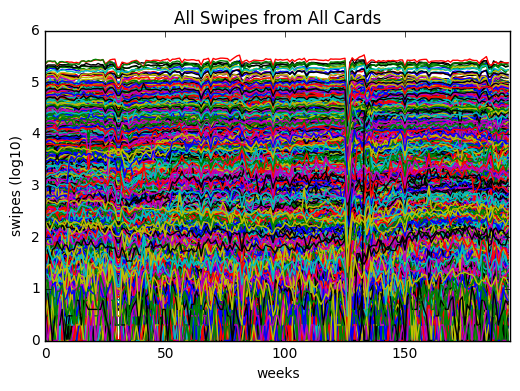

In [5]:
# reshape the np cube to 2D and plot all rides from all cardtype
mtaRide_allswipes = mtaRide.reshape(600*23, 194)
plt.plot(np.log10(mtaRide_allswipes).T)
plt.title("All Swipes from All Cards")
plt.xlabel("weeks")
plt.ylabel("swipes (log10)")
plt.xlim(0, 194)
plt.show()

#### Picture 1: Time series of swipes in every station for every type of card

### Task 1:
#### Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series. Identify it, figure out the date (you know when the data starts and what the cadence is) and figure out what it is due to.

To know where the drop is, I summarized all the time series at Picture 1 into 1 time series with sum.

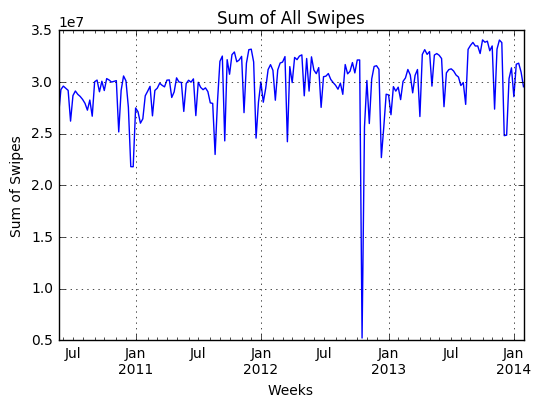

In [8]:
mta_allsum = np.nansum(mtaRide_allswipes, axis=0)

# create a dataframe containing sum of all swipes and date range
sum_swipes = pd.DataFrame({'sum':mta_allsum.T},
                                index = dateRange)

# plot the time series
ax = sum_swipes.plot(grid=True, title="Sum of All Swipes",
                     legend=False)
ax.set_xlabel("Weeks")
ax.set_ylabel("Sum of Swipes")

#### Picture 2: Time series of sum of all swipes. We can clearly see there is a huge drop there.

In [10]:
# set threshold = 3*sigma
threshold = 3*sum_swipes['sum'].std()

# subset the dataframe based on the threshold
sum_swipes[(sum_swipes['sum'] < threshold)]

,sum
2012-10-21,5218686.0


From the result we might conclude that the huge drop happened on October 21, 2012. But since the data was aggregated per week, we cannot say October 21, 2012 is the exact date, instead, the event happened between October 21, 2012 and October 28, 2012. **It was Hurricane Sandy**

### Task 2:
#### Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the ridership types that have steadily increased in popularity, and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

In [11]:
# first, we have to summarize the swipes by card type:
sum_by_cardtype= np.nansum(mtaRide, axis=0)

# create a dataframe with dateRange as columns, ridetype as index
df_sum_by_cardtype = pd.DataFrame(sum_by_cardtype,
                                 columns=dateRange,
                                 index=ridetype)

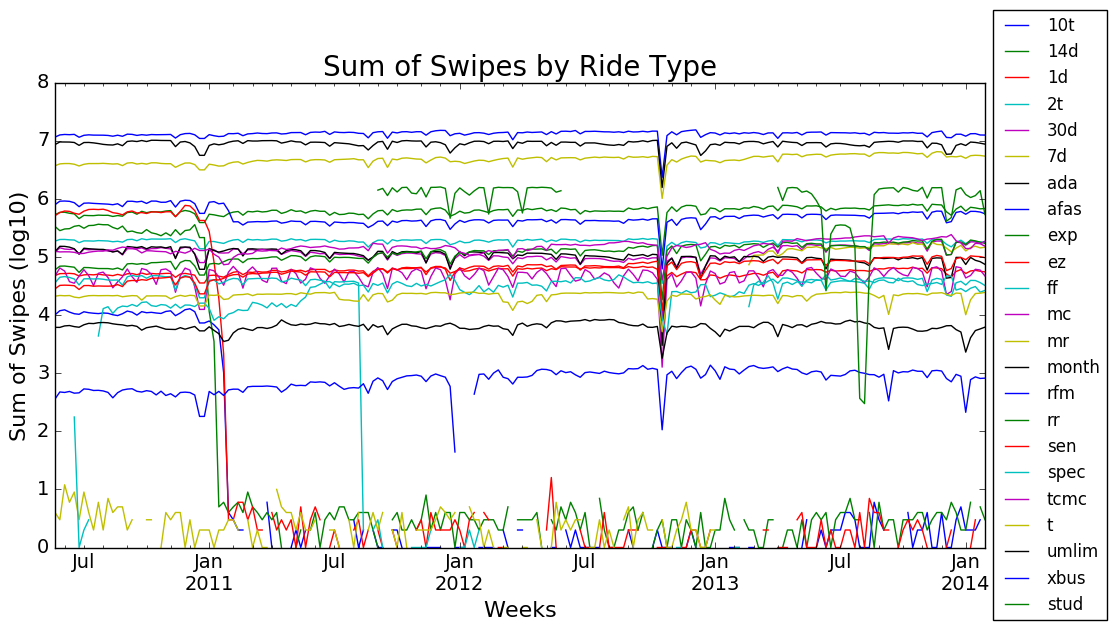

In [54]:
# plot the data with log 10
ax = np.log10(df_sum_by_cardtype).T.plot(figsize=(12,6), fontsize=14)
ax.set_title("Sum of Swipes by Ride Type", fontsize=20)
ax.legend(loc='center left', bbox_to_anchor=(1,0.5))
ax.set_xlabel("Weeks", fontsize=16)
ax.set_ylabel("Sum of Swipes (log10)", fontsize=16)

#### Picture 3: Timeseries of sum of swipes by ridetype / cardtype. Here we can not really see the trend.
To see the trend within each time series, we use rolling means by factor 10 weeks. Then, we compare the ratio of first 10 weeks mean with the last 10 weeks mean. We look at differences between these 2 rolling means and divide it by last 10 weeks mean. Positive result indicating an increasing trend, otherwise, it's a decreasing trend.

In [67]:
rolling_mean = pd.rolling_mean(df_sum_by_cardtype.T, 10).dropna()
rm_sorted_index = rolling_mean.T.iloc[:,0].sort_values(ascending=False).index

# then
first10 = rolling_mean.iloc[0]
last10 = rolling_mean.iloc[-1]
ratio =((last10 - first10)/last10).sort_values(ascending=False)
print "ratio of usage (increasing by how much):"
print ratio

ratio of usage (increasing by how much):
stud          1.000000
mr            0.999960
spec          0.985751
sen           0.656286
rr            0.614340
xbus          0.398434
tcmc          0.347374
7d            0.280445
14d           0.201319
mc            0.175965
1d            0.100190
30d           0.032683
10t           0.021333
t             0.021133
2t           -0.070889
ada          -0.111307
ff           -0.221296
umlim        -0.235996
rfm          -0.539389
month        -0.727944
afas      -4773.478261
exp      -93570.342857
ez      -665797.555556
dtype: float64


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=10,center=False).mean()
  if __name__ == '__main__':


In [65]:
print "card with increasing trend:"
print ratio[ratio>0].index.values
print "card with decreasing trend:"
print ratio[ratio<0].index.values

card with increasing trend:
['stud' 'mr' 'spec' 'sen' 'rr' 'xbus' 'tcmc' '7d' '14d' 'mc' '1d' '30d'
 '10t' 't']
card with decreasing trend:
['2t' 'ada' 'ff' 'umlim' 'rfm' 'month' 'afas' 'exp' 'ez']


Since we only compare the first 10 weeks mean with the last 10 weeks mean, it is possible that there is a significant jump / drop between those 2 periods, resulting an unsteady progression. To justify our result, let's plot all the rolling means:

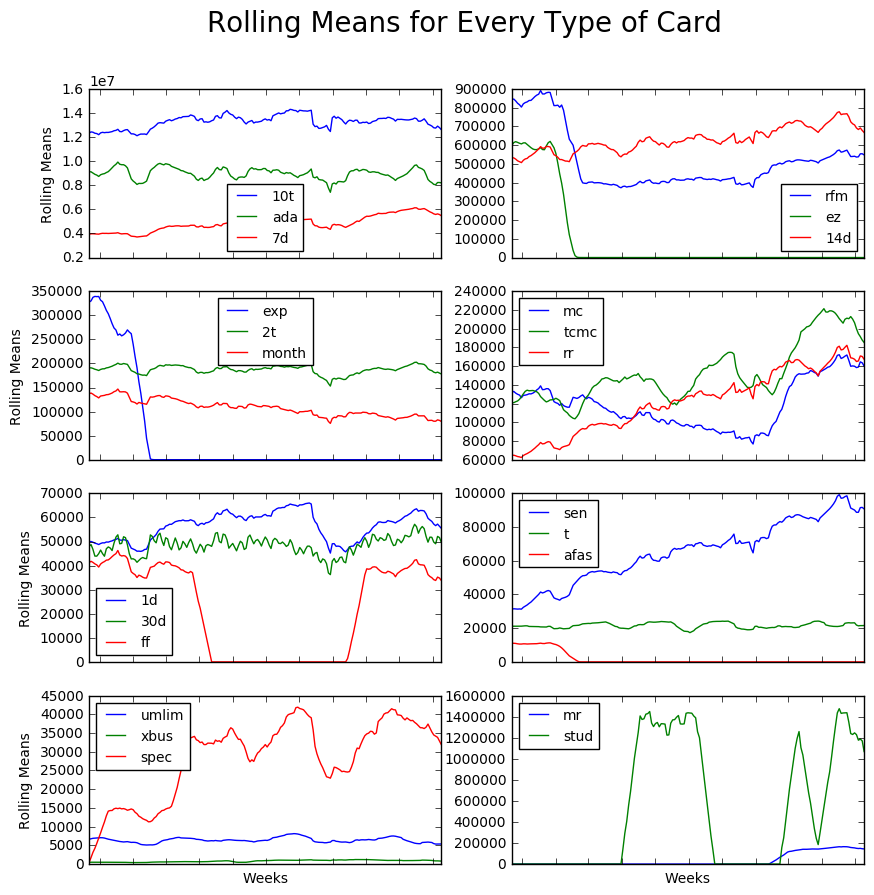

In [66]:
# plot the rolling mean
fig, axs = plt.subplots(4,2, figsize=(10,10))
axs = axs.ravel()

for i in range(8):
    cols = rm_sorted_index[3*i:3*(i+1)]
    for j in range(len(cols)):
        axs[i].plot(rolling_mean.loc[:,cols[j]], label=cols[j])
    axs[i].legend(loc='best', prop={'size':10})
    labels = axs[i].get_xticklabels()
    plt.setp(labels, visible=False)
    if (i==6) | (i==7):
        axs[i].set_xlabel("Weeks")
    if i%2 == 0:
        axs[i].set_ylabel("Rolling Means")
plt.suptitle("Rolling Means for Every Type of Card", fontsize=20)

#### Picture 4: Rolling means of every card type. Here we can see some cards have increasing trend, some are decreasing, and the others show more fluctuative trends

Now we can see there are some cards that are not steadily decreasing / increasing, such as rfm, ez, exp, ff, mr, and stud.

### Task 3:
#### Several stations show a prominent annual periodicity. Identify the 4 stations (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

Since we are going to compare the trend of each station, we have to summarize the data first:

In [68]:
sum_by_station = np.nansum(mtaRide,axis=1)
sum_by_station = pd.DataFrame(sum_by_station.T,
            index=dateRange)

Now, we have to plot the fourier transformation for each time series

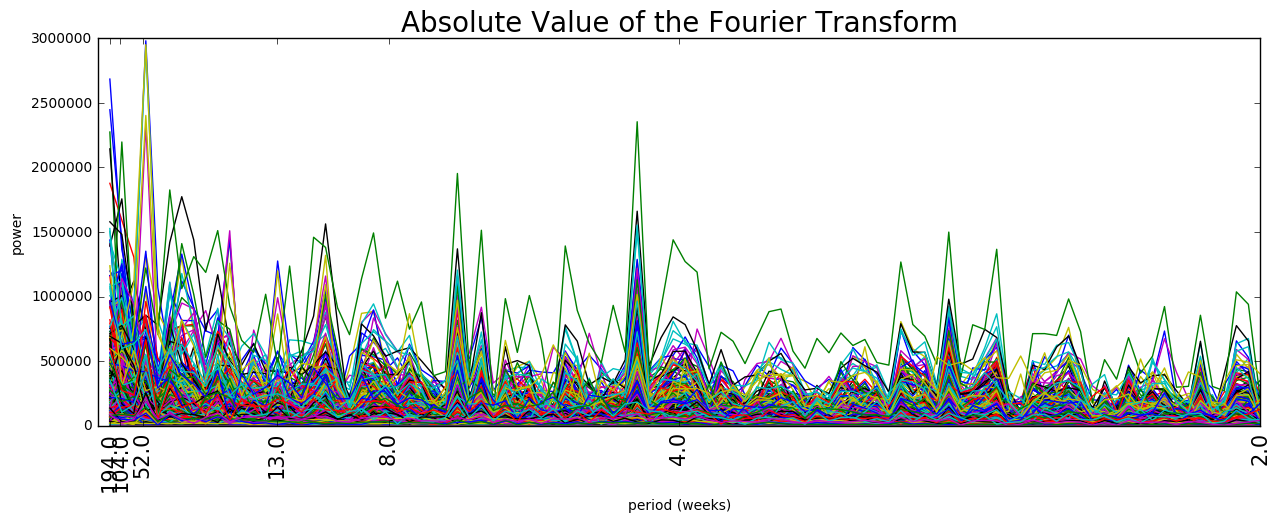

In [73]:
fig=plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
fft = pd.DataFrame()
for i in range(600):
    f = np.abs(np.fft.rfft(sum_by_station[i]))
    ax.plot(np.fft.rfftfreq(194, 1.0)[1:], (f[1:]), '-')
    fft = pd.concat([fft,pd.DataFrame(f)],axis=1)
fft.columns = range(600)
ax.set_xticks([1./194,1./104,1./52,1./13,1./8,0.25,0.5])
ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], rotation=90, fontsize=15)
plt.xlabel("period (weeks)")
plt.ylabel("power")
plt.title("Absolute Value of the Fourier Transform", fontsize=20)
plt.show()

#### Picture 5: Absolute value of the fourier transform. There is a highest jump in 52 period (weeks), indicating annual trend.
To know which station has the annual trend, I figure out in which index the 52 actually lies by looking at the fft index containing the most power (highest peak).

In [74]:
max_within_fft = fft.iloc[1:,:].apply(max,axis=1)
print 'fft index contains the most power is:'
print max_within_fft.sort_values(ascending=False).head(1)

fft index contains the most power is:
4    2.980161e+06
dtype: float64


Now that we know the index, we have to find the stations by calling that index (4)

In [75]:
top4 = fft.ix[4].sort_values(ascending=False).head(4)
top4

0      2.980161e+06
194    2.950389e+06
150    2.931896e+06
327    2.402219e+06
Name: 4, dtype: float64

So, the stations with annual trend are 0, 194, 150, 327. Let's plot them to know how the timeseries looks like.

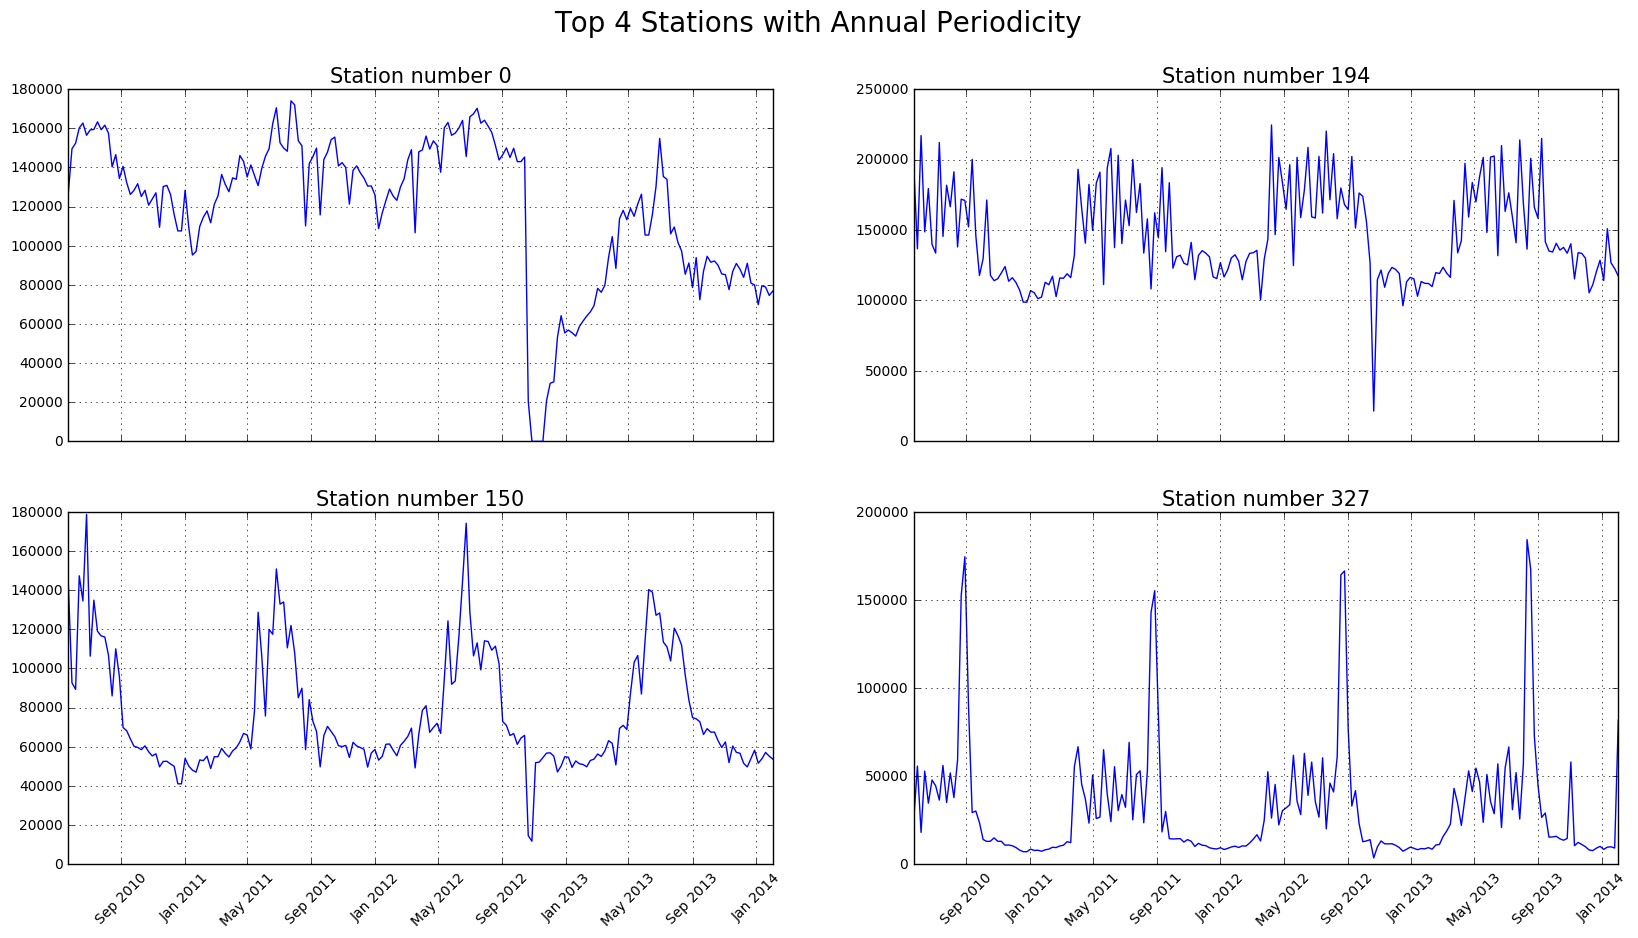

In [76]:
fig = plt.figure(figsize=(20, 10))

for i in range(4):
    ax = plt.subplot(2,2,i+1)
    ax.plot(sum_by_station[top4.index[i]])
    labels = ax.get_xticklabels()
    if (i+1 == 3) | (i+1 == 4):
        plt.setp(labels, rotation=45, fontsize=10)
    else:
        plt.setp(labels, visible=False)
    plt.grid(which='both')
    plt.title('Station number ' + str(top4.index[i]), fontsize=15)
plt.suptitle('Top 4 Stations with Annual Periodicity', fontsize=20)
plt.show()

#### Picture 6: Top 4 station with annual periodicity. Looking at this plot, we can see that it goes high between May and September each year. 
So potentially, the periodic peak in rides is due to the changing season: more rides in every summer because of more tourists coming in. In station number 327, we can see very high peak there in every first week of September. This station probably near one of the campus (Columbia?) when the students and family are busy with back-to-school events.

## Extra Credit
Clustering the time series. To do so, we have to reshape and filter the data first.

In [77]:
data = mtaRide

# reshape
tots = data.transpose(2,0,1).reshape(data.shape[2], data.shape[1]*data.shape[0]).T

# filter
tots = tots[tots.std(1)>0]

# normalize
vals = ((tots.T - tots.mean(1))/tots.std(1)).T

And then, apply the clustering method. Here I use 10 for the number of cluster

In [78]:
km = KMeans(10)
res = km.fit(vals)

Plot the data

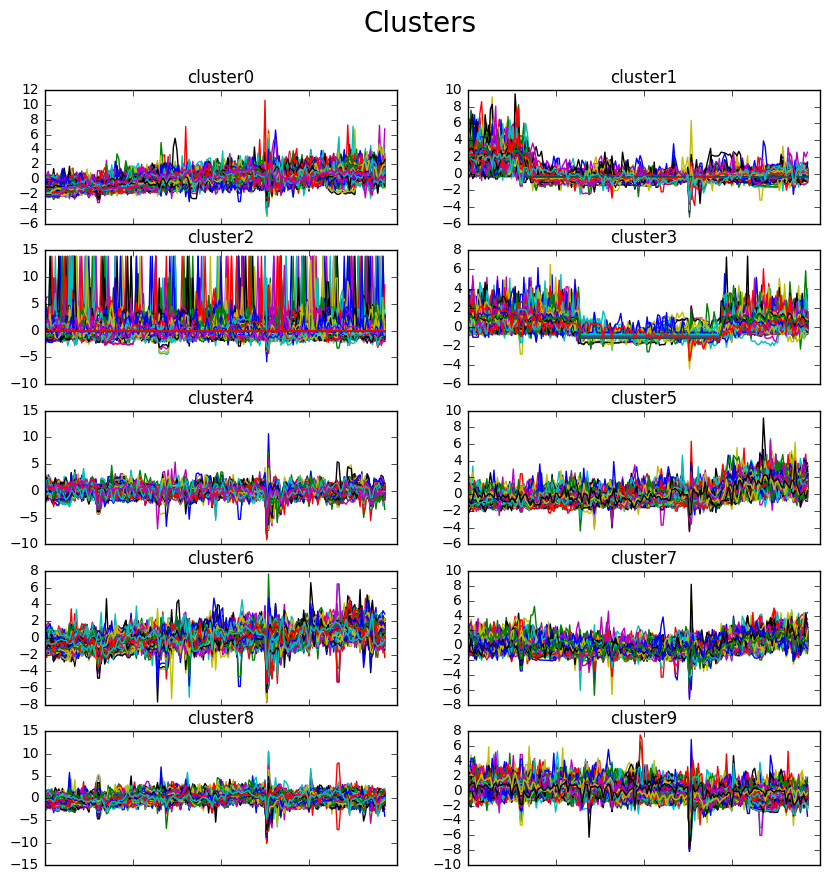

In [79]:
fig, axs = plt.subplots(5,2, figsize=(10, 10))
axs = axs.ravel()

for i in range(10):
    axs[i].plot(vals[np.where(res.labels_==i)].T)
    axs[i].set_title('cluster' + str(i), fontsize=12)
    plt.setp(axs[i].get_xticklabels(), visible=False)
plt.suptitle('Clusters', fontsize=20)
plt.show()

#### Picture 7: Ten clusters of time series.